In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import cv2
import PIL
import os

In [2]:
vgg = tf.keras.applications.VGG19(include_top = False, weights = "imagenet")

for layers in vgg.layers:
    print(f"{layers.name} ---> {layers.output_shape}")    

input_1 ---> [(None, None, None, 3)]
block1_conv1 ---> (None, None, None, 64)
block1_conv2 ---> (None, None, None, 64)
block1_pool ---> (None, None, None, 64)
block2_conv1 ---> (None, None, None, 128)
block2_conv2 ---> (None, None, None, 128)
block2_pool ---> (None, None, None, 128)
block3_conv1 ---> (None, None, None, 256)
block3_conv2 ---> (None, None, None, 256)
block3_conv3 ---> (None, None, None, 256)
block3_conv4 ---> (None, None, None, 256)
block3_pool ---> (None, None, None, 256)
block4_conv1 ---> (None, None, None, 512)
block4_conv2 ---> (None, None, None, 512)
block4_conv3 ---> (None, None, None, 512)
block4_conv4 ---> (None, None, None, 512)
block4_pool ---> (None, None, None, 512)
block5_conv1 ---> (None, None, None, 512)
block5_conv2 ---> (None, None, None, 512)
block5_conv3 ---> (None, None, None, 512)
block5_conv4 ---> (None, None, None, 512)
block5_pool ---> (None, None, None, 512)


In [3]:
def gram_matrix(input_tensor):
    
    gram_matrix = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    gram_matrix = tf.expand_dims(gram_matrix, axis = 0)
    input_shape = tf.shape(input_tensor)
    i_j = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    gram_matrix = gram_matrix/i_j
    
    return gram_matrix

In [4]:
def load_model():
    
    vgg = tf.keras.applications.VGG19(include_top = False, weights = "imagenet")
    vgg.trainable = False
    content_layers = ["block4_conv2"]
    style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
    content_output = vgg.get_layer(content_layers[0]).output
    style_outputs = [vgg.get_layer(style).output for style in style_layers]
    gram_style_output = [gram_matrix(style) for style in style_outputs]
    
    model = tf.keras.models.Model([vgg.input], [content_output, gram_style_output])
    return model

D:\Machine Learning\Machine Learning Projects\Neural_Style_Transfer


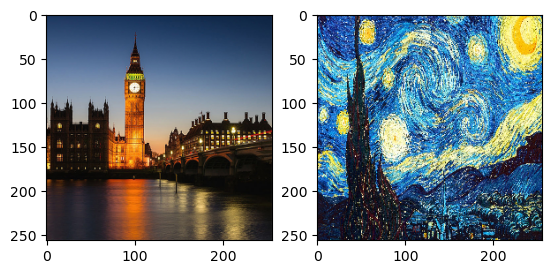

In [5]:
%matplotlib inline

path = os.getcwd()
print(path)

content_image = cv2.imread(path + "\examples\content_images\stat.png")
if content_image is None:
    print("Wrong Path")
else:
    content_image = cv2.resize(content_image, (256,256))
    content_image = tf.image.convert_image_dtype(content_image, tf.float32)       

style_image = cv2.imread(path + "\examples\style_images\\starry-night.jpg" )
if style_image is None:
    print("Wrong Path")
else:
    style_image = cv2.resize(style_image, (256,256))
    style_image = tf.image.convert_image_dtype(style_image, tf.float32)

plt.subplot(121)
plt.imshow(cv2.cvtColor(np.array(content_image), cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.imshow(cv2.cvtColor(np.array(style_image), cv2.COLOR_BGR2RGB ))

plt.show()

In [6]:
content_image.shape

TensorShape([256, 256, 3])

In [7]:
style_image.shape

TensorShape([256, 256, 3])

In [8]:
def cal_loss(content_output, content_input, style_output, style_input):
    
    content_weight = 1e-6
    style_weight = 7e0
    content_loss = tf.reduce_mean((content_output - content_input)**2)
    style_loss = [tf.reduce_mean(output_ - input_)**2 for output_, input_ in zip(style_output, style_input)]
    style_loss = tf.add_n(style_loss)
    
    total_loss = style_weight*style_loss + content_weight*content_loss
    
    return total_loss

In [9]:
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [10]:
vgg = load_model()
content_target = vgg(np.array([content_image*255]))[0]
style_target = vgg(np.array([style_image*255]))[1]

In [11]:
def training(image, epoch):
    with tf.GradientTape() as tape:
        output = vgg(image*255)
        loss = cal_loss(output[0],content_target, output[1],style_target )
    gradient = tape.gradient(loss, image)
    optimizer.apply_gradients([(gradient, image)])
    image.assign(tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0))
    
    print(f"epoch no. = {epoch} -----> loss = {loss}")
        

In [12]:
epochs = 10
image = tf.image.convert_image_dtype(content_image, tf.float32)
image = tf.Variable([image])
for i in range(epochs):
    training(image, i)

epoch no. = 0 -----> loss = 2085902614528.0
epoch no. = 1 -----> loss = 1391399403520.0
epoch no. = 2 -----> loss = 666287341568.0
epoch no. = 3 -----> loss = 211549601792.0
epoch no. = 4 -----> loss = 24649529344.0
epoch no. = 5 -----> loss = 45409034240.0
epoch no. = 6 -----> loss = 127703629824.0
epoch no. = 7 -----> loss = 136184512512.0
epoch no. = 8 -----> loss = 78554144768.0
epoch no. = 9 -----> loss = 23647508480.0


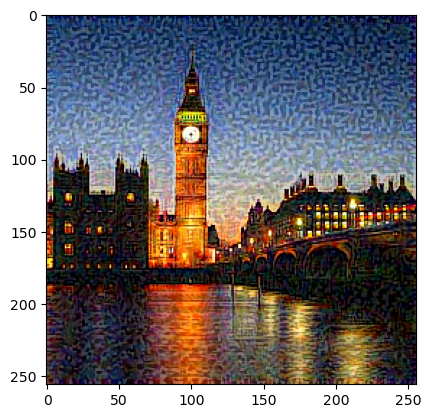

In [13]:
import PIL
tensor = image*255
tensor = np.array(tensor, dtype=np.uint8)
if np.ndim(tensor)>3:
  assert tensor.shape[0] == 1
  tensor = tensor[0]
tensor =  PIL.Image.fromarray(tensor)
plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))
plt.show()